In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name,num_labels=3)
model.config.hidden_dropout_prob = 0.2
model.config.attention_probs_dropout_prob = 0.2



Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Load and Prepare CLEAR Corpus

In [2]:

aito_comment = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Capstone/Data/annotated_translated_aito_comment.xlsx")
li_comment = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Capstone/Data/annotated_translated_li_comment.xlsx")
df = pd.concat([aito_comment, li_comment])
columns_to_keep = ['translation', 'sentiment']

# Create a new DataFrame with only the specified columns
df = df[columns_to_keep]
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=['sentiment'], inplace=True)
df.reset_index(drop=True, inplace=True)

clear_df = df.sample(n=10000, random_state=42)

In [3]:
clear_df['translation']

28288    Why didn't the two children choose the sixth s...
20066    The appearance is extremely ugly, like a desig...
29377    Why did the China Insurance Research Institute...
9097     I've been explaining for half a day, but still...
11127    Charging directly with oil is ok, don't talk n...
                               ...                        
18651    Is the aluminum alloy bumper beam broken at bo...
3399                               Interested in this car.
13437          You are suitable for the M1 children's car.
33311    Have vision, have attractiveness, have connota...
21724           Listen to you, prepare to pick up the car.
Name: translation, Length: 10000, dtype: object

In [4]:
clear_df['sentiment'] = clear_df['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

In [5]:
clear_df

,translation,sentiment
28288,Why didn't the two children choose the sixth s...,1
20066,"The appearance is extremely ugly, like a desig...",0
29377,Why did the China Insurance Research Institute...,1
9097,"I've been explaining for half a day, but still...",1
11127,"Charging directly with oil is ok, don't talk n...",0
...,...,...
18651,Is the aluminum alloy bumper beam broken at bo...,1
3399,Interested in this car.,2
13437,You are suitable for the M1 children's car.,1
33311,"Have vision, have attractiveness, have connota...",2


In [ ]:
#!pip install jieba

In [ ]:
#import jieba
#def divide_comments(comment):
#    return ' '.join(jieba.cut(comment))
#clear_df['divided_comment']= clear_df['comment'].apply(divide_comments)

In [ ]:
#clear_df.replace([np.inf, -np.inf], np.nan, inplace=True)
#clear_df.dropna(subset=['sentiment'], inplace=True)
#clear_df['divided_comment'] = clear_df['divided_comment'].astype(str)
clear_df['sentiment'] = clear_df['sentiment'].astype(int)

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(list(clear_df['translation']), list(clear_df['sentiment']), test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [7]:
from torch.utils.data import DataLoader, Dataset

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }




In [8]:
train_dataset = SentimentDataset(X_train, y_train, tokenizer)
val_dataset = SentimentDataset(X_val, y_val, tokenizer)
test_dataset = SentimentDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    i = 0
    for batch in loader:
        optimizer.zero_grad()
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], labels=batch['labels'])
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        i=i+1
        #print("Step"+str(i)+" Loss:"+str(total_loss))
    return total_loss / len(loader)


from sklearn.metrics import accuracy_score, precision_recall_fscore_support,classification_report

def evaluate(model, loader):
    model.eval()
    total_loss = 0
    predictions, true_labels = [], []
    loss_fn = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in loader:
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'],labels=batch['labels'])
            loss = outputs.loss
            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())

    # Calculate evaluation metrics
    average_val_loss = total_loss / len(loader)
    accuracy = accuracy_score(true_labels, predictions)
    report = classification_report(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='macro')
    return average_val_loss,accuracy, precision, recall, f1,report







In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-6)
epochs = 50
train_loss_history = []
average_val_loss_history = []

# Early stopping parameters
patience = 3  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer)
    train_loss_history.append(train_loss)

    average_val_loss, accuracy, precision, recall, f1, report = evaluate(model, val_loader)
    average_val_loss_history.append(average_val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {average_val_loss:.4f}, "
          f"Validation Accuracy: {accuracy:.4f}, Validation precision: {precision:.4f}, "
          f"Validation recall: {recall:.4f}, Validation F1: {f1:.4f}")

    # Early stopping logic
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        patience_counter = 0  # Reset counter

        # Save the model with validation metrics
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_val_loss,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
        torch.save(checkpoint, f'/content/drive/MyDrive/Colab Notebooks/Capstone/checkpoints/model_English_bert_epoch_{epoch}.pth')
        print("Validation loss improved, resetting patience counter.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epoch(s).")
        if patience_counter >= patience:
            print("Stopping early due to lack of improvement in validation loss.")
            break





/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/50, Train Loss: 1.0485, Validation Loss: 0.9725, Validation Accuracy: 0.5073, Validation precision: 0.6977, Validation recall: 0.4196, Validation F1: 0.3725
Validation loss improved, resetting patience counter.
Epoch 2/50, Train Loss: 0.8941, Validation Loss: 0.7775, Validation Accuracy: 0.6613, Validation precision: 0.6532, Validation recall: 0.6635, Validation F1: 0.6573
Validation loss improved, resetting patience counter.
Epoch 3/50, Train Loss: 0.7634, Validation Loss: 0.7422, Validation Accuracy: 0.6773, Validation precision: 0.6672, Validation recall: 0.6878, Validation F1: 0.6742
Validation loss improved, resetting patience counter.
Epoch 4/50, Train Loss: 0.7002, Validation Loss: 0.7161, Validation Accuracy: 0.6900, Validation precision: 0.6850, Validation recall: 0.6867, Validation F1: 0.6858
Validation loss improved, resetting patience counter.
Epoch 5/50, Train Loss: 0.6631, Validation Loss: 0.7193, Validation Accuracy: 0.6853, Validation precision: 0.6808, Validati

In [ ]:
average_val_loss, accuracy, precision, recall, f1, report = evaluate(model, test_loader)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", report)

Accuracy: 0.692
Precision: 0.6846915262137695
Recall: 0.6886675685368472
F1 Score: 0.6864616410769955

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.76      0.75       635
           1       0.64      0.61      0.62       552
           2       0.67      0.69      0.68       313

    accuracy                           0.69      1500
   macro avg       0.68      0.69      0.69      1500
weighted avg       0.69      0.69      0.69      1500



In [ ]:


# Save the model weights
model_path = "/content/drive/MyDrive/Colab Notebooks/Capstone/model_English_weights.bin"
torch.save(model.state_dict(), model_path)

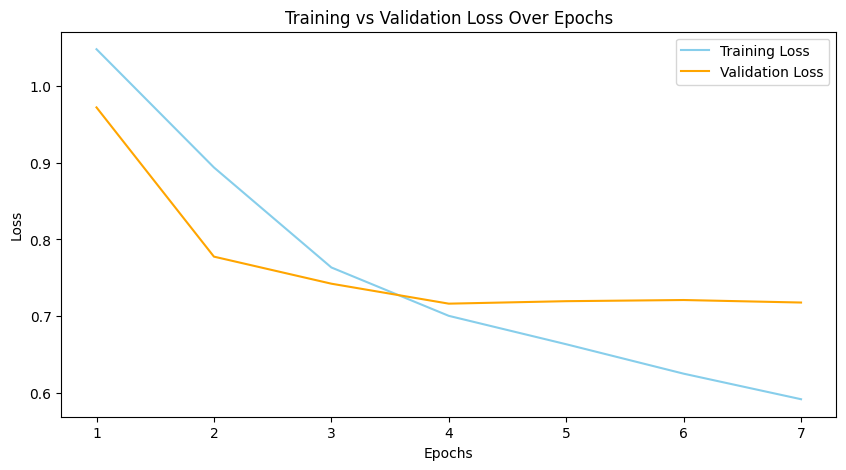

In [ ]:
# Now plot them
x_values = [x for x in range(1,len(train_loss_history)+1)]

# Now plot them with appropriate color and name
plt.figure(figsize=(10, 5))  # Adjust the figure size if needed
plt.plot(x_values, train_loss_history, label='Training Loss', color='skyblue')  # Set the color and label for training loss
plt.plot(x_values, average_val_loss_history, label='Validation Loss', color='orange')  # Set color and label for validation loss

# Add labels, a legend, and display the plot
plt.title('Training vs Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Capstone/saved_English_bert.png')
plt.show()
